In this notebook, we will check if we can build a classifier that can predict labels for a sequence of images. We will combine CNN and LSTM layers to build a model. CNN is used as a feature extractor and LSTM layers are used to understand temporal features of the sequence of images.

### Initial Setup

* Import all libraries

In [1]:
import os
from collections import Counter
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_video import VideoFrameGenerator

* Converting sequential images to video

We will convert the image sequences that we have into videos using the following function. The images that belong to a sequence have similar names. We will use that information to prepare the training and test datasets.

In [71]:
def images_to_videos(folder_names, classes):
    if not os.path.exists('videos'):
        os.makedirs('videos')
    for folder in folder_names:
        if not os.path.exists('videos/' + folder):
            os.makedirs('videos/' + folder)
        for class_name in classes:
            if not os.path.exists('videos/' + folder + '/' + class_name):
                os.makedirs('videos/' + folder + '/' + class_name)
            image_folder = 'images/' + folder + '/' + class_name
            files_list = os.listdir(image_folder)
            filenames = []
            for files in files_list:
                filenames.append(files[0:4])
            
            # Keeping videos with at least 5 frames
            files_dict = {k: v for k, v in Counter(filenames).items() if v > 4}
            for file, count in files_dict.items():
                images = [img for img in os.listdir(image_folder) if img[0:4] == file]
                frame = cv2.imread(os.path.join(image_folder, images[0]))
                height, width, layers = frame.shape
                
                video_name = 'videos/' + folder + '/' + class_name + '/' + file + '_video.avi'
                video = cv2.VideoWriter(video_name, 0, 1, (width, height))
                
                for image in images:
                    video.write(cv2.imread(os.path.join(image_folder, image)))
                cv2.destroyAllWindows()
                video.release()
    return None

images_to_videos(folder_names, classes)

* Initialize image folder path and other parameters

In [2]:
#tf.debugging.set_log_device_placement(True)

IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = "videos/training"
TEST_DATA_DIR = "videos/testing"
EVAL_DIR = "final_evaluation"
BATCH_SIZE = 8
EPOCHS=50
FRAMES = 5
CHANNELS = 3

# The dataset is labelled 'flip' and 'notflip'
folder_names = ['training', 'testing']
classes = ['flip', 'notflip']

glob_train_pattern = TRAINING_DATA_DIR + '/{classname}/*.avi'
glob_test_pattern = TEST_DATA_DIR + '/{classname}/*.avi'

Training data contains 117 videos, whereas testing data is made of 65 videos

In [3]:
print("Total Number of training data:", sum(len(files) for f, s, files in os.walk(TRAINING_DATA_DIR)))
print("Total Number of testing data:", sum(len(files) for f, s, files in os.walk(TEST_DATA_DIR)))

Total Number of training data: 117
Total Number of testing data: 65


#### Create a custom classifier that combines CNN and LSTM layers

Step 1: Load the videos and prepare the training and testing dataset to build a classifier. We have separated the videos based on their labels and placed them in different folders. Similar to ImageDataGenerator that assists the flow of single images from directories to the models. We will use VideoFrameGenerator that can pass multiple images at a time as the input to the ML models. Unfortunately, the videos do not have same number of frames. We will pick 5 distributed images from the entire video that can capture a sequence.

In [4]:
tf.random.set_seed(42)

data_augmentation = ImageDataGenerator(zoom_range=.1,
                                       horizontal_flip=True,
                                       rotation_range=8,
                                       width_shift_range=.2,
                                       height_shift_range=.2,)

training_set = VideoFrameGenerator(classes=classes,
                                   rescale=1./255,
                                   glob_pattern=glob_train_pattern,
                                   nb_frames=FRAMES,
                                   shuffle=True,
                                   batch_size=BATCH_SIZE,
                                   target_shape=IMAGE_SHAPE,
                                   nb_channel=CHANNELS,
                                   transformation=data_augmentation,
                                   use_frame_cache=False,)

test_set = VideoFrameGenerator(classes=classes,
                               rescale=1./255,
                               glob_pattern=glob_test_pattern,
                               nb_frames=FRAMES,
                               shuffle=True,
                               batch_size=BATCH_SIZE,
                               target_shape=IMAGE_SHAPE,
                               nb_channel=CHANNELS,
                               use_frame_cache=False,)

Total data: 2 classes for 117 files for train
Total data: 2 classes for 65 files for train


Step 2: Build the classifier model

* We will use time distributed convnets to extract features from multiple frames in a sequence. The timedistributed layer is used to ensure the same layers process all the images in a sequence.
* The output from the convnets is injected into LSTM or GRU to treat the "Sequence"
* Dense layers are used to take the decision to classify

In [5]:
momentum = .9
classifier_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=8, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    #tf.keras.layers.BatchNormalization(momentum=momentum),
    tf.keras.layers.GlobalMaxPool2D()])

def my_model(shape=(5, 224, 224, 3)):
    model = tf.keras.Sequential([tf.keras.layers.TimeDistributed(classifier_model, input_shape=shape),
                                tf.keras.layers.LSTM(128),
                                tf.keras.layers.Dense(64, activation='relu'),
                                #tf.keras.layers.Dropout(0.5),
                                tf.keras.layers.Dense(2, activation='sigmoid')])
    return model
    


Step 3: Train the neural network with the training dataset and validate it using test dataset.

In [6]:
SHAPE = (FRAMES, ) + IMAGE_SHAPE + (CHANNELS,)
model = my_model(shape=SHAPE)
callback = [tf.keras.callbacks.ReduceLROnPlateau(verbose=1)]

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = 'binary_crossentropy',
              metrics=["accuracy"])


model_history = model.fit(training_set,
                          epochs=EPOCHS,
                          validation_data=test_set,
                          callbacks=callback,)

Epoch 1/50
14/14 [==============================] - 123s 8s/step - loss: 0.6978 - accuracy: 0.5089 - val_loss: 0.7040 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 2/50
14/14 [==============================] - 10s 667ms/step - loss: 0.6893 - accuracy: 0.5625 - val_loss: 0.7089 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 3/50
14/14 [==============================] - 5s 341ms/step - loss: 0.6913 - accuracy: 0.5446 - val_loss: 0.6972 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 4/50
14/14 [==============================] - 5s 342ms/step - loss: 0.6856 - accuracy: 0.5625 - val_loss: 0.7003 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 5/50
14/14 [==============================] - 5s 337ms/step - loss: 0.6824 - accuracy: 0.5536 - val_loss: 0.7060 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 6/50
14/14 [==============================] - 5s 349ms/step - loss: 0.6724 - accuracy: 0.5625 - val_loss: 0.6928 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/50
14/14 [==============================] - 5s 375ms/step - lo

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 64)            24528     
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 131,730
Trainable params: 131,730
Non-trainable params: 0
_________________________________________________________________


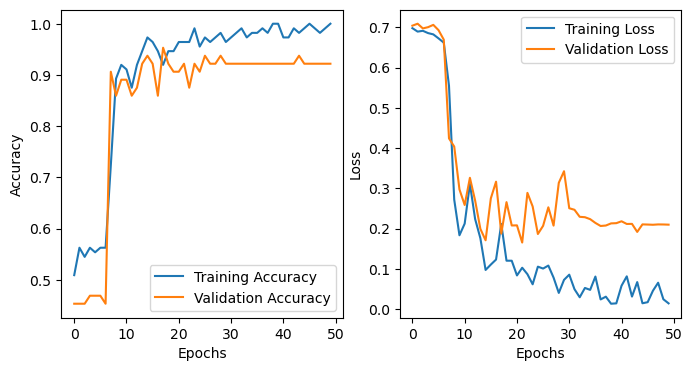

In [8]:
def plot_curves(model):    
    fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
    ax[0].plot(range(EPOCHS), model.history['accuracy'], label="Training Accuracy")
    ax[0].plot(range(EPOCHS), model.history['val_accuracy'], label="Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    ax[1].plot(range(EPOCHS), model.history['loss'], label="Training Loss")
    ax[1].plot(range(EPOCHS), model.history['val_loss'], label="Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.show()
    
plot_curves(model_history)

#### Summary

We can acheive almost 93% accuracy while classifying a sequence of images. The real challenge is to get large enough datset of videos to perfrom effective training. Additionally, we can observe that loss and accuracy fluctuate because of the small batch size. Training the model with a larger dataset will give consistent results. Furthermore, pre-trained models can be used to build effective feature extractors that can perform effective sequence classification.